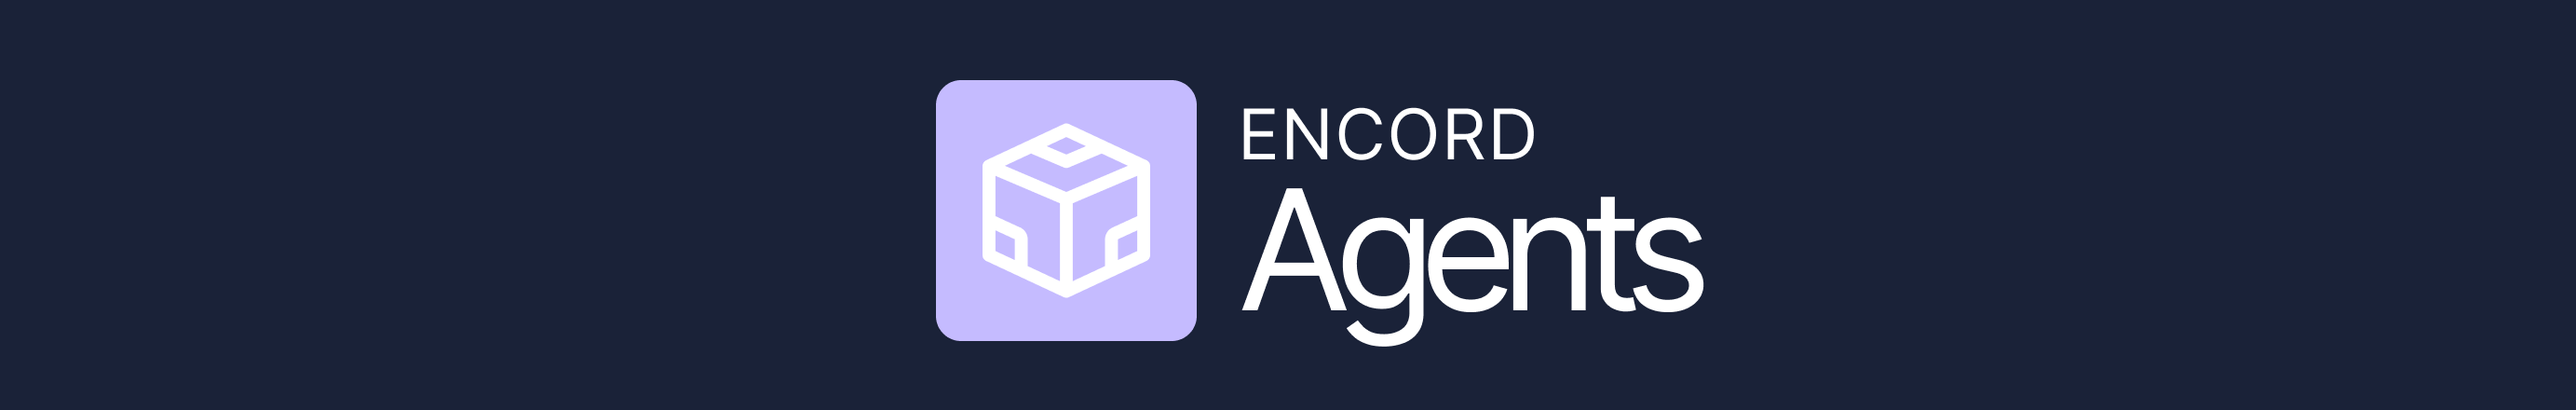

# Sentiment Analysis


This notebook walks you through using an AI-powered Agent to analyze the "high confidence" transcriptions on audio files from the **Darization** agent.

## Example Workflow

The following workflow illustrates how audio files can be reviewed after pre-labelling by the [**Darization** agent](https://agents-docs.encord.com/notebooks/audio_transcription_agent_multi_speaker/).

> If you haven't already, please consider [the notebook](https://agents-docs.encord.com/notebooks/audio_transcription_agent_multi_speaker/) for more details on how to first transcribe the audio.

The code in this notebook is for the **Sentiment analysis** agent.


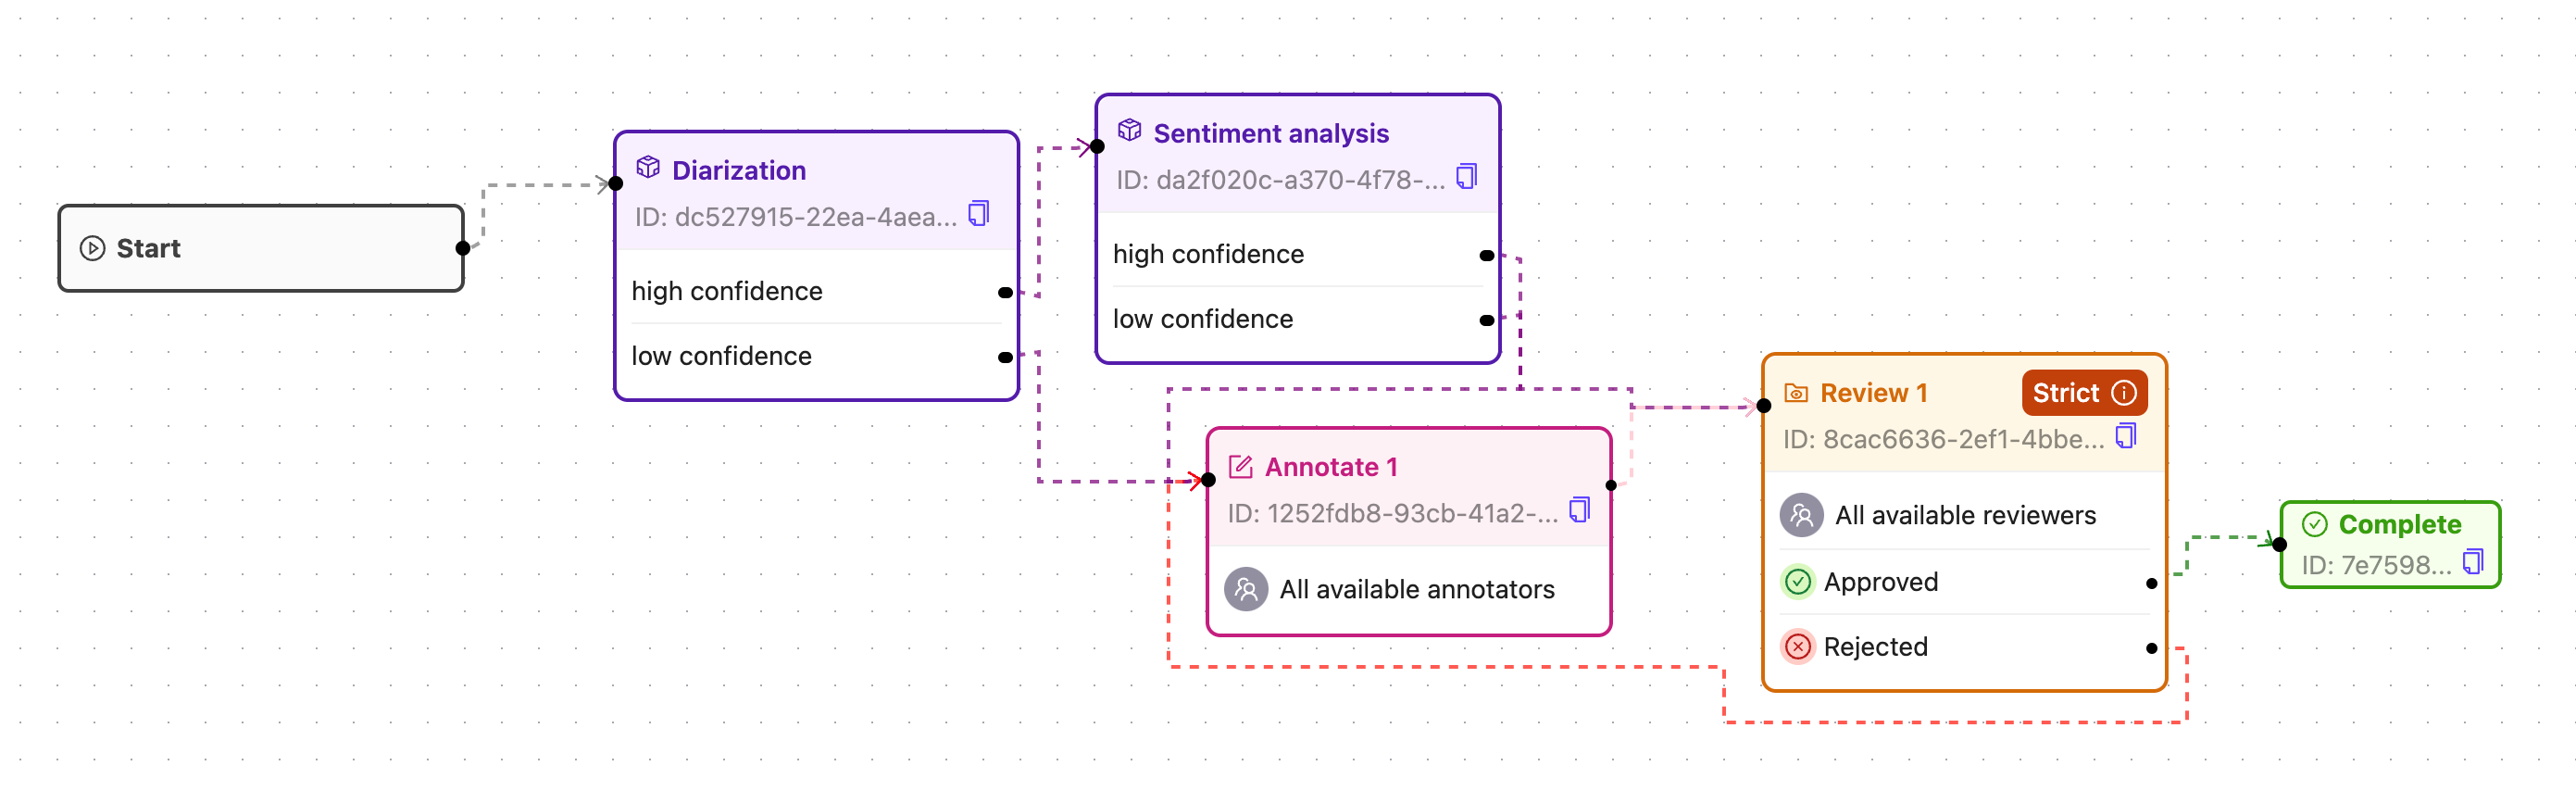

### Installation

Install the `encord-agents` and `transformers` libraries:

In [ ]:
!python -m pip install -q encord-agents
!python -m pip install -q transformers

## Pipeline

This code uses the transformers library from Hugging Face to create a sentiment analysis pipeline. It initializes a sentiment analysis model and applies it to the given text: "Covid cases are increasing fast!". The model returns a sentiment label ("high confidence" or "low confidence") along with a confidence score.

In [ ]:
from transformers import pipeline

sentiment_task = pipeline("sentiment-analysis")

# Example inference
sentiment_task("Covid cases are increasing fast!")

## Workflow creation

Verify the Workflow being used in your Project is the same as the one outlined in the earlier section of this notebook. The important thing here is that it begins with an agent node that routes to the annotation node. Naming is not important.

[📖 here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-workflows-and-templates#creating-workflows) is the documentation for creating a workflow with Encord.

## Ontology

For this project, we need to have "Audio Object"s with two nested classifications.
One object for each speaker ("speaker" should be in the name of the object).

* `"utterance"` (TextAttribute) which holds the transcription to read and do sentiment analysis on.
* `"sentiment"` (RadioAttribute) to store the sentiment of the transcription with three options: "positive", "neutral", "negative".


Here is an example of one such speaker entry:

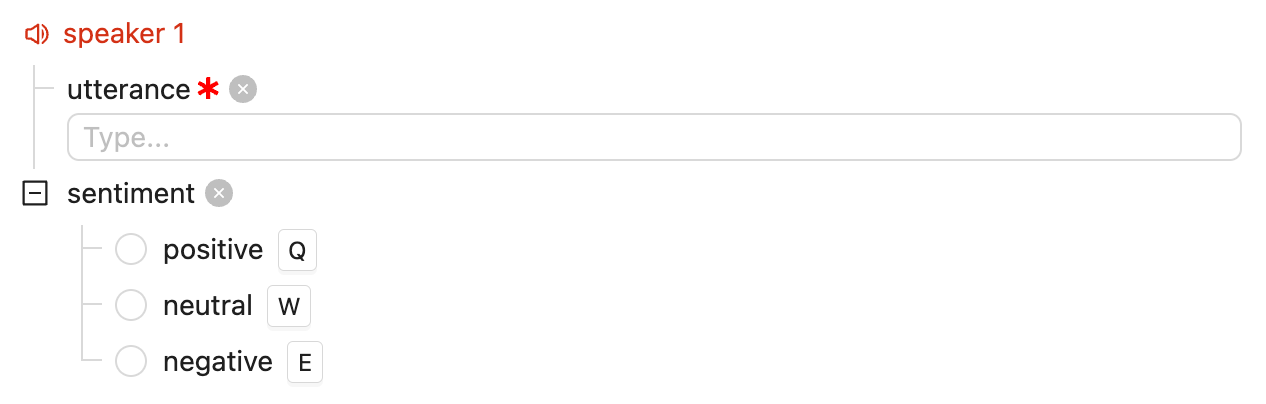

## Authentication

The library authenticates via ssh-keys. Below, is a code cell for setting the ENCORD_SSH_KEY environment variable. It should contain the raw content of your private ssh key file.

If you have not yet setup an ssh key, please follow the [documentation](https://agents-docs.encord.com/authentication/).

> 💡 **Colab users**: In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks with
> ```python
> from google.colab import userdata
> key_content = userdata.get("ENCORD_SSH_KEY")
> ```

In [ ]:
import os

from google.colab import userdata

os.environ["ENCORD_SSH_KEY"] = "YOUR_KEY_GOES_HERE"
# or this if you want to reuse
# os.environ["ENCORD_SSH_KEY"] = userdata.get("ENCORD_SSH_KEY")

## Running the Agent

This script integrates Hugging Face's sentiment analysis model with Encord's annotation pipeline using encord_agents.

1. A Runner instance is initialized with a specific project ID.
2. A processing stage, "Sentiment analysis", is defined.
3. The function do_analysis extracts textual data (utterances) from objects in a LabelRowV2.
4. The text is analyzed for sentiment using transformers' sentiment-analysis pipeline.
5. Based on the sentiment (positive, negative, or neutral), the corresponding label is assigned to the object.
6. The updated labels are saved back to the annotation row.
7. The function returns "high confidence" as an indicator of task completion.



This setup automates sentiment labeling in Encord Annotate by leveraging pre-trained NLP models.

In [ ]:
from encord.objects.ontology_labels_impl import LabelRowV2

from encord_agents.tasks import Runner

runner = Runner("<Your project ID>")

In [ ]:
@runner.stage("Sentiment analysis")
def do_analysis(label_row: LabelRowV2):
    texts = []
    object_instances = label_row.get_object_instances()
    for o in object_instances:
        attr = o.ontology_item.get_child_by_title("utterance")
        answer = o.get_answer(attribute=attr)
        texts.append(answer)
    sentiments = sentiment_task(texts)
    for o, s in zip(object_instances, sentiments):
        idx = 0 if s["label"] == "POSITIVE" else 2 if s["label"] == "NEGATIVE" else 1
        opt = o.ontology_item.get_child_by_title("sentiment").options[idx]
        o.set_answer(opt)
    label_row.save()
    return "high confidence"

To execute the agent, run the following command:

In [ ]:
runner()

> 💡*Hint:* If you execute this as a Python script, you can run it as a command line interface by putting the above code in an `agents.py` file and replacing
> ```python
> runner()
> ```
> with
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```
> Which allows you to set, for example the Project hash using the command line:
> ```bash
> python agent.py --project-hash "..."
> ```
